In [1]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from userfunctions import *

In [2]:
#plt.style.use('default')
sns.set()

In [3]:
#загрузили исходные данные
df_raw = pd.read_excel(r'Prioksk_Air_in.xlsx')
#очистили их от того, что не потребуется и что может привести к ошибкам
df = PrepareDataFrame(df_raw.copy())
#создадим копию для удобства
data_total = df.copy()
winter_data, spring_data, summer_data, autumn_data = PrepareSeasonalDataFrame(df.copy())

Некорректные строки удалены:

        YY  MM  DD  TSP  SO2  SO4   HG   PB   CD  NO2
5187  1998   9  31  NaN  0.0  NaN  NaN  NaN  NaN  NaN


# SO2

In [4]:
ELEM_NAME = 'SO2'
ELEM = CreateDataBySeasons(ELEM_NAME
                           , data_total, winter_data, spring_data, summer_data, autumn_data
                           , with_zero=True)
VALUES = ExtractValues(ELEM)

if CountZerosInData(VALUES['all'], ELEM_NAME) > 0:
    #НЕ словарь, просто массив по полной выборке соответ-го элемента
    ELEM_NOT_NULL = CreateDataBySeasons(ELEM_NAME
                                        , data_total, winter_data, spring_data, summer_data, autumn_data
                                        , with_zero=False)
    VALUES_NOT_NULL = ExtractValues(ELEM_NOT_NULL)
else:
    VALUES_NOT_NULL = VALUES

Число нулевых элементов в полной выборке SO2: 81



Гистограмма для полной выборки SO2


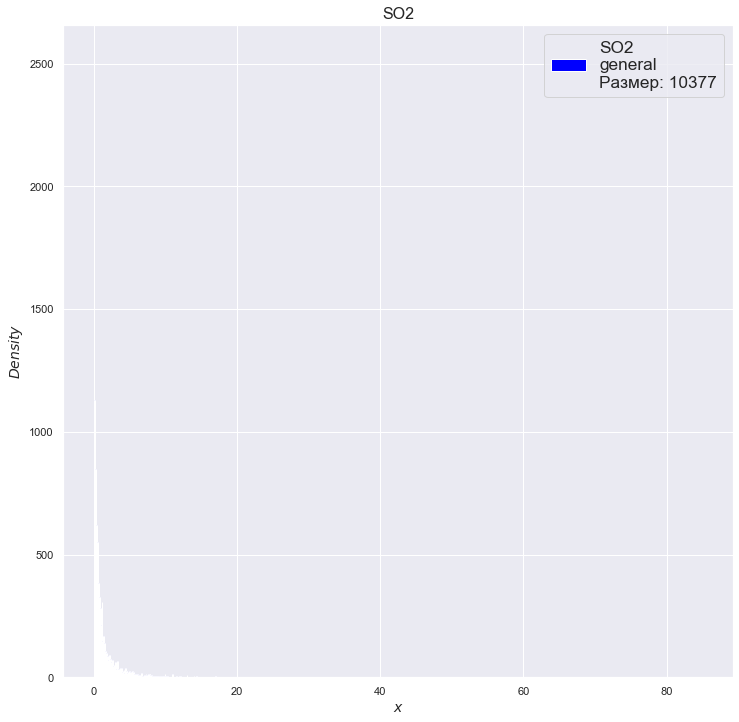

In [5]:
HistOnSample(VALUES['all'],ELEM_NAME)

In [18]:
start = datetime.datetime.now()
distr_ks, params_ks, p_v_ks, distr_chi2, params_chi2, p_v_chi2 = GetBestDistribution(VALUES_NOT_NULL['all'])
print ('\nTook time: {0}'.format(datetime.datetime.now()-start))


Chi2
Best fitting distribution: lognorm
Best p value: 0.06129408382432025
Parameters for the best fit: (1.5376970370438245, 0.0029146624832760443, 0.4504738754612615)

K-S
Best fitting distribution: gengamma
Best p value: 3.7899248666196734e-08
Parameters for the best fit: (6.500949412897285, 0.25696610497057537, 0.0033127133533884766, 0.00041332412393099206)

Took time: 0:02:03.309804


In [19]:
distr_params_all = defaultdict(dict)
if p_v_ks >= 0.05:
    distr_params_all['general'][distr_ks] = params_ks
if p_v_chi2 >= 0.05:
    distr_params_all['general'][distr_chi2] = params_chi2

Text(0.5, 1.0, 'SO2')

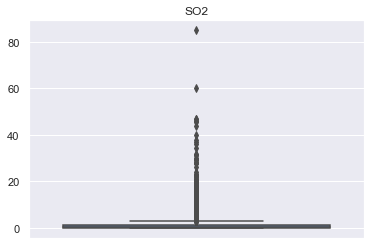

In [6]:
#sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(VALUES['all'],orient='v').set_title(ELEM_NAME)

In [149]:
SizeSample(VALUES['all'], ELEM_NAME)
k = CountZerosInData(VALUES['all'], ELEM_NAME)
CountByTreshold(VALUES['all'], ELEM_NAME, 0.1 , 0.01)

Размер полной выборки для SO2 равен 10377
Число нулевых элементов в полной выборке SO2: 81

Посмотрим на число элементов выше и ниже некоторых порогов для выборки SO2

Порог: 0.0, значений выше: 10296, ниже: 81
Порог: 0.01, значений выше: 10194, ниже: 183
Порог: 0.02, значений выше: 10170, ниже: 207
Порог: 0.03, значений выше: 10054, ниже: 323
Порог: 0.04, значений выше: 10046, ниже: 331
Порог: 0.05, значений выше: 9242, ниже: 1135
Порог: 0.06, значений выше: 9222, ниже: 1155
Порог: 0.07, значений выше: 9196, ниже: 1181
Порог: 0.08, значений выше: 9180, ниже: 1197
Порог: 0.09, значений выше: 9164, ниже: 1213
Порог: 0.1, значений выше: 7846, ниже: 2531


Построение графика всей выборки для SO2


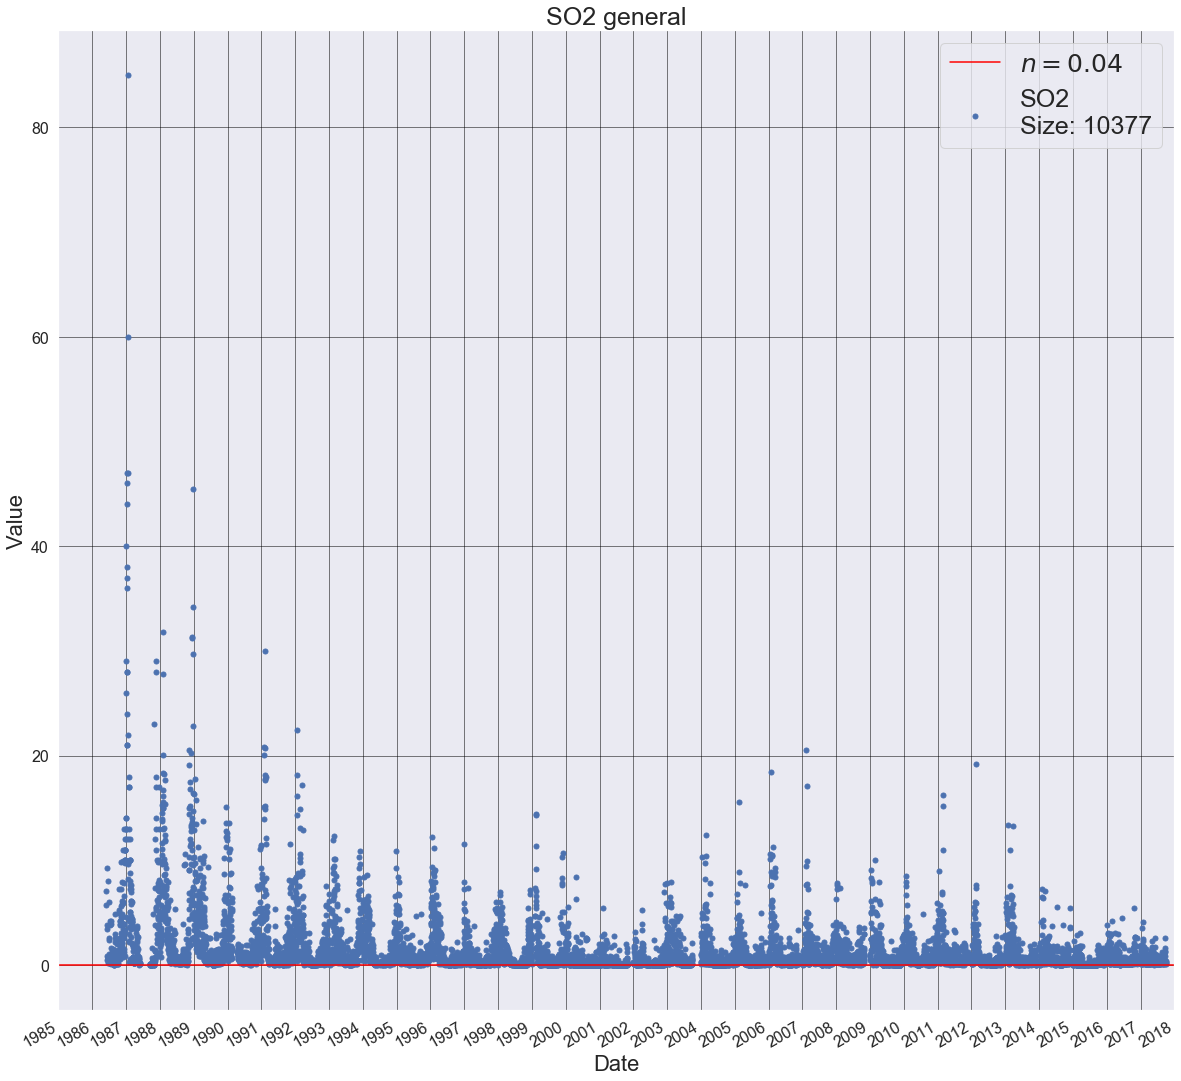

In [8]:
PlotElement(ELEM['all'],ELEM_NAME,'general',20,20,0.04)

Гистограмма 0-1 теста Колмогорова-Смирнова для выборки SO2


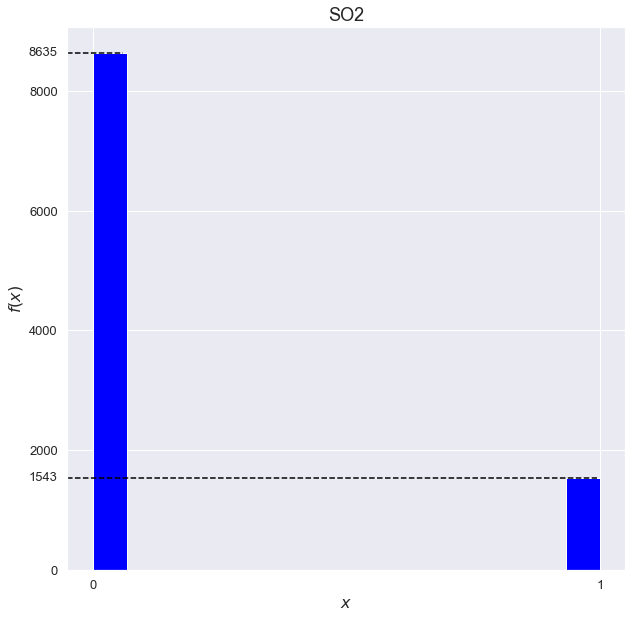

In [155]:
HistOnKSTest2Sample(KSTest2Sample(VALUES['all']), ELEM_NAME)

Принимаем гипотезу однородности К-С, если p-value > 0.05, сопоставляем ей 1, иначе 0
Число подряд идущих 1 - синим цветом, 0 - серым 


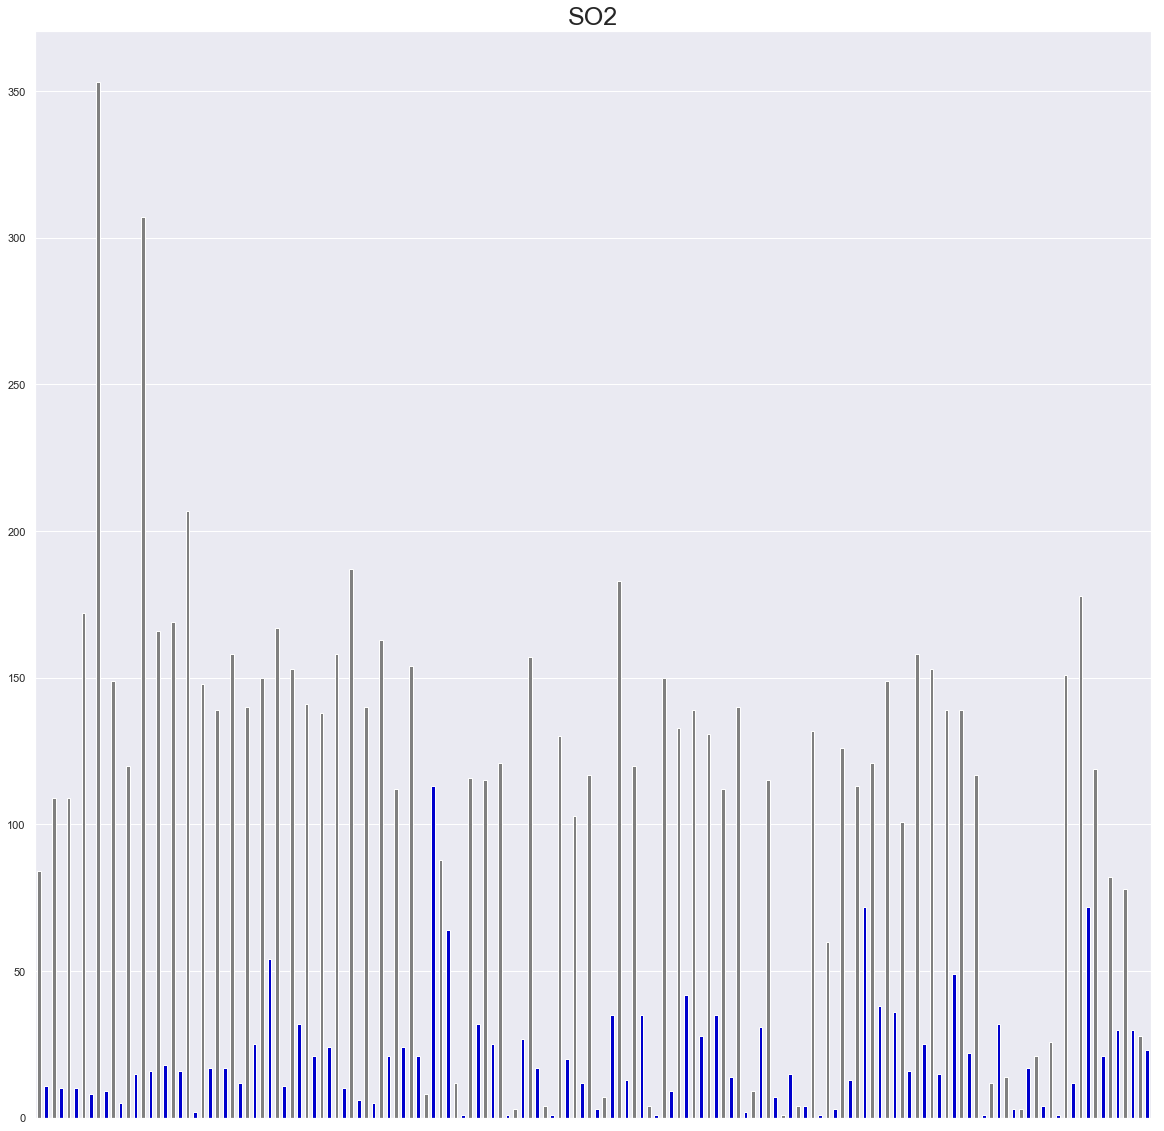

In [156]:
HistOnRepValues(RepeatedValuesCount(KSTest2Sample(VALUES['all'])),ELEM_NAME)

Поделим выборку на train и test (90 к 10), по 1-й оценим параметры, по 2-й проверим гипотезу о согласии К-С и Хи-квадрат для Гамма распределения

**Гамма уже не подбирается**


In [ ]:
#GAMMA

#проверим на гамма распределение более "внимательно"
#можно попробовать 0.1, тогда быстро находит

test_size = 0.1

while True: 
    train, test = train_test_split(VALUES_NOT_NULL['all'], test_size=test_size)
    params = FitParams(train,'gamma', floc=0)
    s_chi2, p_chi2 = ChiSquareOnTest(test, 'gamma', params)
    s_ks, p_ks = KSOnTest(test, 'gamma', params)
    if p_chi2 >= 0.05 or p_ks >= 0.05:
        break
#based on chi2 and ks
#SO2
print('shape,loc,scale = {0}, p_v on Chi2 = {1}, p_v on KS = {2}'.format(params, p_chi2, p_ks))


Гистограмма для выборки SO2, сезон - general
Поверх нее строятся теоритические функции плотности вероятности с вычисленными параметрами


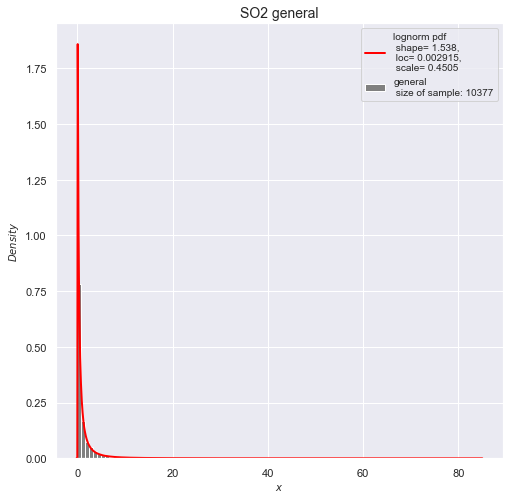

In [26]:
fig2 = DistributionBySeason(VALUES['all'], ELEM_NAME, 'general', distr_params_all['general'])
fig2.savefig(ELEM_NAME+'_DistrAll.png', bbox_inches='tight', pad_inches=0)

## Рассмотрим сезонные выборки

In [161]:
params_seasons = {}

In [27]:
start = datetime.datetime.now()
seasons = ['winter', 'spring', 'summer', 'autumn']
params_seasons_ks,params_seasons_chi2 = defaultdict(dict), defaultdict(dict)
train_test_seasons1 = {}
for s in seasons:
    print()
    print(s.upper())
    print()
    distr_ks,params_ks,p_v_ks, distr_chi2,params_chi2, p_v_chi2 = GetBestDistribution(VALUES_NOT_NULL[s])
    if p_v_ks >= 0.05:
        params_seasons_ks[s][distr_ks] = params_ks
    if p_v_chi2 >= 0.05:
        params_seasons_chi2[s][distr_chi2] = params_chi2
print('\nTook time: {0}'.format(datetime.datetime.now()-start))


WINTER


Chi2
Best fitting distribution: mielke
Best p value: 0.3445331854564677
Parameters for the best fit: (0.8486485251599578, 1.7693034040062023, 0, 3.5078018817835144)

K-S
Best fitting distribution: powerlognorm
Best p value: 0.9373395978084439
Parameters for the best fit: (32.27805820652786, 2.8571017183043903, 0, 561.9730490846475)

SPRING


Chi2
Best fitting distribution: lognorm
Best p value: 0.5909385311116168
Parameters for the best fit: (1.2839932054766043, -0.0015431542452550395, 0.5515739664543321)

K-S
Best fitting distribution: recipinvgauss
Best p value: 0.1350924150369842
Parameters for the best fit: (4.162467125837027, 0, 0.9016279946095578)

SUMMER


Chi2
Best fitting distribution: invgamma
Best p value: 0.47890670748529884
Parameters for the best fit: (0.9142089490816725, 0, 0.09001835215961831)

K-S
Best fitting distribution: ncf
Best p value: 5.897256684842293e-06
!!!Optimal Distribution on K-S was not found!!!

AUTUMN


Chi2
Best fitting distribution: invgamm

In [29]:
distr_params_seasons = defaultdict(dict)
for s in seasons:
    try:
        distr_ks, params_ks = list(params_seasons_ks[s].keys())[0], list(params_seasons_ks[s].values())[0] 
        distr_params_seasons[s][distr_ks] = params_ks
    except IndexError:
        continue
for s in seasons:
    try:
        distr_chi2, params_chi2 = list(params_seasons_chi2[s].keys())[0], list(params_seasons_chi2[s].values())[0] 
        distr_params_seasons[s][distr_chi2] = params_chi2
    except IndexError:
        continue
#for s in seasons:
    #params_gamma = params_seasons[s]
    #distr_params_seasons[s]['gamma'] = params_gamma
    

Гистограмма для выборки SO2, сезон - winter
Поверх нее строятся теоритические функции плотности вероятности с вычисленными параметрами


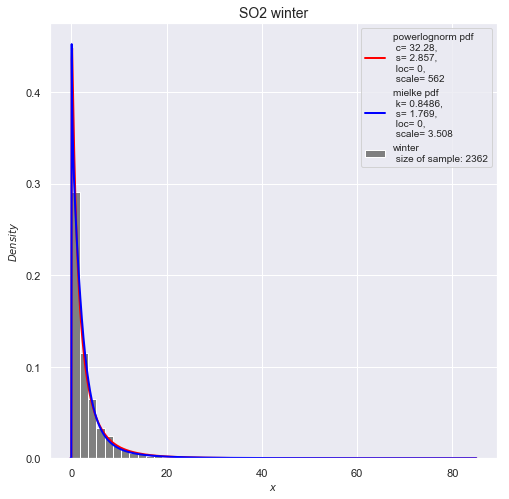

Гистограмма для выборки SO2, сезон - spring
Поверх нее строятся теоритические функции плотности вероятности с вычисленными параметрами


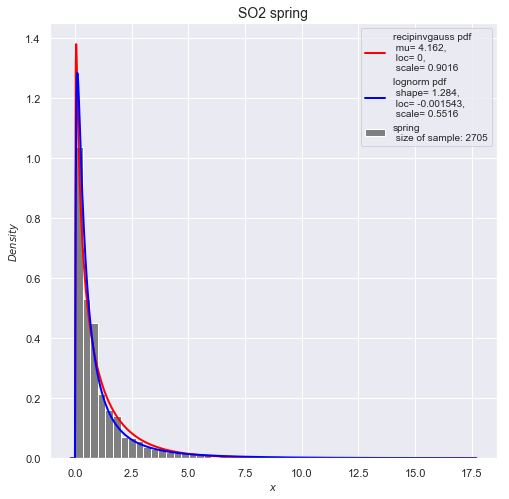

Гистограмма для выборки SO2, сезон - summer
Поверх нее строятся теоритические функции плотности вероятности с вычисленными параметрами


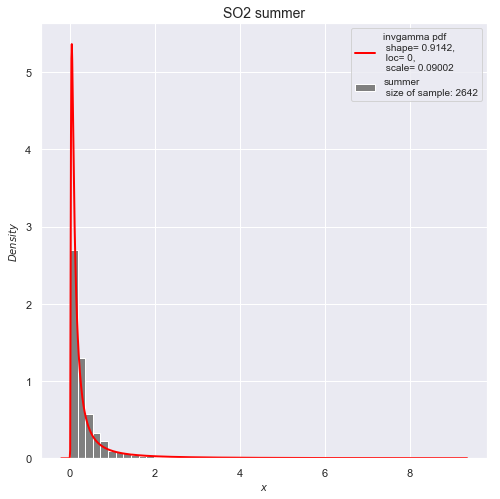

Гистограмма для выборки SO2, сезон - autumn
Поверх нее строятся теоритические функции плотности вероятности с вычисленными параметрами


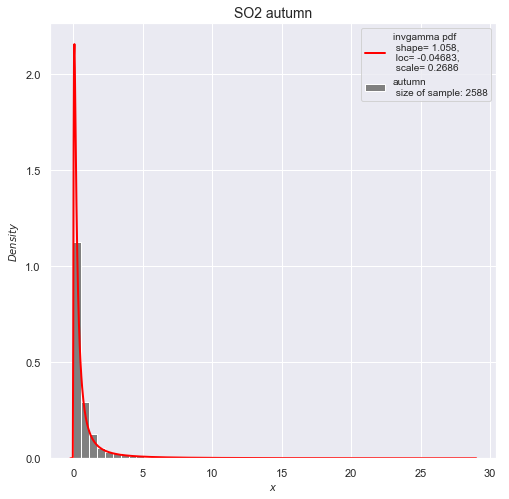

In [31]:
for s in seasons:
    DistributionBySeason(VALUES_NOT_NULL[s], ELEM_NAME, season=s,params_dict=distr_params_seasons[s])

### Проверка гипотезы о согласии Хи-квадрат и К-С для сезонных выборок для Гамма распределения
#### для других подобранных распределений результаты выше

In [79]:
print('PROPORTIONS OF SEASON DATA FROM ALL DATA')
print('WINTER:', len(VALUES['winter'])/len(VALUES['all']), sep=' ')
print('SPRING:', len(VALUES['spring'])/len(VALUES['all']), sep=' ')
print('SUMMER:', len(VALUES['summer'])/len(VALUES['all']), sep=' ')
print('AUTUMN:', len(VALUES['autumn'])/len(VALUES['all']), sep=' ')

PROPORTIONS OF SEASON DATA FROM ALL DATA
WINTER: 0.22771513925026501
SPRING: 0.26076900838392597
SUMMER: 0.2586489351450323
AUTUMN: 0.2528669172207767


## Гамма распределение изначально не подобралось, соответственно смесь тоже

